# Retail Sales Data

## Imports

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

## Read files

In [86]:
df_retail = pd.read_csv("../data/retail-sales.csv", 
                          sep=";", 
                          skiprows=7,    # skip the first 7 rows with metadata
                          header=None,
                          engine='python')
df_bsr = pd.read_csv('../data/trash-amounts.csv', sep=";")

## Prepare retail data

In [87]:
# column names
df_retail.columns = [
    'Bundesland', 'Jahr', 'Monat', 'Umsatz_konstant', 
    'marker1', 'Veraenderung_konstant', 'marker2', 
    'Umsatz_aktuell', 'marker3', 'Veraenderung_aktuell', 'marker4'
]

# fill empty state names and years with forward fill
df_retail[['Bundesland', 'Jahr']] = df_retail[['Bundesland', 'Jahr']].ffill()

# only use data for Berlin
df_retail = df_retail[df_retail['Bundesland'] == 'Berlin']

# map month names to numbers
month_map = {
    "Januar": 1, "Februar": 2, "März": 3, "April": 4,
    "Mai": 5, "Juni": 6, "Juli": 7, "August": 8,
    "September": 9, "Oktober": 10, "November": 11, "Dezember": 12
}
df_retail['Monat'] = df_retail['Monat'].map(month_map)

# convert year to numeric
df_retail['Jahr'] = pd.to_numeric(df_retail['Jahr'], errors='coerce')

# drop rows with missing values
df_retail = df_retail.dropna(subset=['Jahr'])

# convert year to integer
df_retail['Jahr'] = df_retail['Jahr'].astype(int)

# convert everything to numeric
df_retail['Umsatz_konstant'] = df_retail['Umsatz_konstant'].str.replace(',', '.')
df_retail['Umsatz_konstant'] = pd.to_numeric(df_retail['Umsatz_konstant'], errors='coerce')
df_retail['Veraenderung_konstant'] = df_retail['Veraenderung_konstant'].str.replace(',', '.')
df_retail['Veraenderung_konstant'] = pd.to_numeric(df_retail['Veraenderung_konstant'], errors='coerce')
df_retail['Umsatz_aktuell'] = df_retail['Umsatz_aktuell'].str.replace(',', '.')
df_retail['Umsatz_aktuell'] = pd.to_numeric(df_retail['Umsatz_aktuell'], errors='coerce')
df_retail['Veraenderung_aktuell'] = df_retail['Veraenderung_aktuell'].str.replace(',', '.')
df_retail['Veraenderung_aktuell'] = pd.to_numeric(df_retail['Veraenderung_aktuell'], errors='coerce')


print("Einzelhandels-Umsatzdaten (konstant):")
print(df_retail.head())

Einzelhandels-Umsatzdaten (konstant):
  Bundesland  Jahr  Monat  Umsatz_konstant marker1  Veraenderung_konstant  \
0     Berlin  2019      1            109.0       e                    2.6   
1     Berlin  2019      2            102.1       e                    4.7   
2     Berlin  2019      3            115.1       e                    1.1   
3     Berlin  2019      4            115.4       e                    6.0   
4     Berlin  2019      5            112.6       e                    4.7   

  marker2  Umsatz_aktuell marker3  Veraenderung_aktuell marker4  
0       e           111.0       e                   3.2       e  
1       e           104.6       e                   5.5       e  
2       e           118.2       e                   1.3       e  
3       e           119.2       e                   6.4       e  
4       e           116.5       e                   5.4       e  


In [88]:
df_retail.drop(['marker1', 'marker2', 'marker3', 'marker4'], axis=1, inplace=True)
df_retail.drop(['Bundesland'], axis=1, inplace=True)

df_retail.rename(columns={'Jahr': 'year', 
                          'Monat': 'month', 
                          'Umsatz_konstant': 'sales_volume_constant', 
                          'Veraenderung_konstant': 'change_constant',
                          'Umsatz_aktuell': 'sales_volume_current',
                          'Veraenderung_aktuell': 'change_current'
                          }, inplace=True)

num_lags = 3
features = ['sales_volume_constant', 'change_constant', 'sales_volume_current', 'change_current']

for feature in features:
    for i in range(1, num_lags+1):
        df_retail[f"{feature}_lag{i}"] = df_retail[feature].shift(i)

print(df_retail.head())

   year  month  sales_volume_constant  change_constant  sales_volume_current  \
0  2019      1                  109.0              2.6                 111.0   
1  2019      2                  102.1              4.7                 104.6   
2  2019      3                  115.1              1.1                 118.2   
3  2019      4                  115.4              6.0                 119.2   
4  2019      5                  112.6              4.7                 116.5   

   change_current  sales_volume_constant_lag1  sales_volume_constant_lag2  \
0             3.2                         NaN                         NaN   
1             5.5                       109.0                         NaN   
2             1.3                       102.1                       109.0   
3             6.4                       115.1                       102.1   
4             5.4                       115.4                       115.1   

   sales_volume_constant_lag3  change_constant_lag1  cha

## Prepare BSR Data

In [89]:
# convert columns to numeric
df_bsr["Jahr"] = pd.to_numeric(df_bsr["Jahr"], errors="coerce")
df_bsr["Monat"] = pd.to_numeric(df_bsr["Monat"], errors="coerce")

# remove rows with NaN values
df_bsr.dropna(subset=["Jahr", "Monat"], inplace=True)

# convert columns to integers
df_bsr["Jahr"] = df_bsr["Jahr"].astype(int)
df_bsr["Monat"] = df_bsr["Monat"].astype(int)

# convert Tonnage to float
df_bsr['Tonnage'] = df_bsr['Tonnage'].str.replace(',', '.').astype(float)

print(df_bsr.head())

   Monat   KW  Jahr     Datum  Hof  Schicht  Tour  Tonnage Abfallart
0      1  1.0  2019  02.01.19  VMF      1.0   1.0     5.59       BIO
1      1  1.0  2019  02.01.19  VMF      1.0   4.0     3.23       BIO
2      1  1.0  2019  02.01.19  VMF      1.0   5.0     5.68       BIO
3      1  1.0  2019  02.01.19  VMF      1.0   6.0     5.48       BIO
4      1  1.0  2019  02.01.19  VMF      1.0   7.0     7.84       BIO


## Merge retail and BSR data

In [90]:
# Sicherstellen, dass die Datentypen übereinstimmen
df_bsr['Jahr'] = df_bsr['Jahr'].astype(int)
df_bsr['Monat'] = df_bsr['Monat'].astype(int)
df_retail['year'] = df_retail['year'].astype(int)
df_retail['month'] = df_retail['month'].astype(int)

# Merge durchführen
df_bsr = pd.merge(df_bsr, 
                  df_retail, 
                  left_on=['Jahr', 'Monat'], 
                  right_on=['year', 'month'], 
                  how='left')

print(df_bsr.head())

   Monat   KW  Jahr     Datum  Hof  Schicht  Tour  Tonnage Abfallart  year  \
0      1  1.0  2019  02.01.19  VMF      1.0   1.0     5.59       BIO  2019   
1      1  1.0  2019  02.01.19  VMF      1.0   4.0     3.23       BIO  2019   
2      1  1.0  2019  02.01.19  VMF      1.0   5.0     5.68       BIO  2019   
3      1  1.0  2019  02.01.19  VMF      1.0   6.0     5.48       BIO  2019   
4      1  1.0  2019  02.01.19  VMF      1.0   7.0     7.84       BIO  2019   

   ...  sales_volume_constant_lag3  change_constant_lag1  \
0  ...                         NaN                   NaN   
1  ...                         NaN                   NaN   
2  ...                         NaN                   NaN   
3  ...                         NaN                   NaN   
4  ...                         NaN                   NaN   

   change_constant_lag2  change_constant_lag3  sales_volume_current_lag1  \
0                   NaN                   NaN                        NaN   
1                 

## Relationship between BSR and Sales

   Jahr  Monat    Tonnage  sales_volume_constant         time
0  2019      1  13.151029                  109.0  2019.000000
1  2019      2  13.233680                  102.1  2019.083333
2  2019      3  13.279736                  115.1  2019.166667
3  2019      4  13.325477                  115.4  2019.250000
4  2019      5  12.855768                  112.6  2019.333333


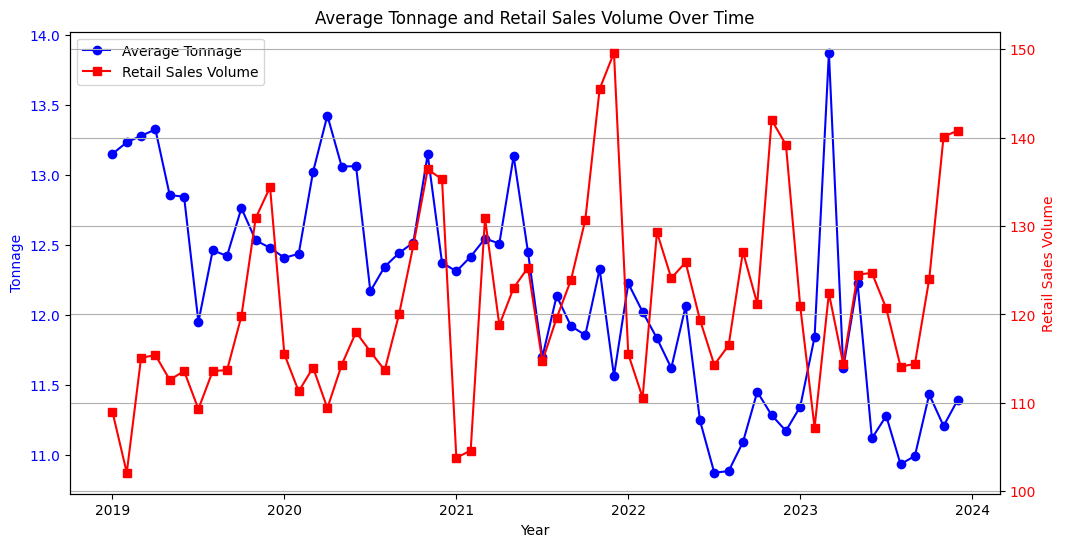

In [91]:
df_grouped = df_bsr.groupby(["Jahr", "Monat"], as_index=False).agg({
    "Tonnage": "mean",                   # Compute the average tonnage per month
    "sales_volume_constant": "mean"         # Retrieve the absolute retail sales volume per month
})

# Create a continuous time axis as a decimal value
# For example, January 2019 becomes 2019.0, February 2019 becomes 2019 + (2-1)/12 ≈ 2019.0833, etc.
df_grouped["time"] = df_grouped["Jahr"] + (df_grouped["Monat"] - 1) / 12

# Print the first few rows to check the grouped data
print(df_grouped.head())

# Create a plot with two y-axes for comparing average tonnage and retail sales volume over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the average tonnage on the left y-axis
ax1.plot(df_grouped["time"], df_grouped["Tonnage"], marker="o", color="blue", label="Average Tonnage")
ax1.set_xlabel("Year")
ax1.set_ylabel("Tonnage", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis for the retail sales volume
ax2 = ax1.twinx()
ax2.plot(df_grouped["time"], df_grouped["sales_volume_constant"], marker="s", color="red", label="Retail Sales Volume")
ax2.set_ylabel("Retail Sales Volume", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Set the title and enable grid
plt.title("Average Tonnage and Retail Sales Volume Over Time")
plt.grid(True)
plt.show()

correlation matrix:
                             Tonnage  sales_volume_constant  \
Tonnage                     1.000000              -0.031269   
sales_volume_constant      -0.031269               1.000000   
sales_volume_constant_lag1 -0.043876               0.457047   
change_constant             0.033658               0.182904   
sales_volume_current       -0.066848               0.866757   
change_current             -0.012487               0.314237   

                            sales_volume_constant_lag1  change_constant  \
Tonnage                                      -0.043876         0.033658   
sales_volume_constant                         0.457047         0.182904   
sales_volume_constant_lag1                    1.000000         0.066018   
change_constant                               0.066018         1.000000   
sales_volume_current                          0.435236        -0.105669   
change_current                                0.208143         0.821429   

            

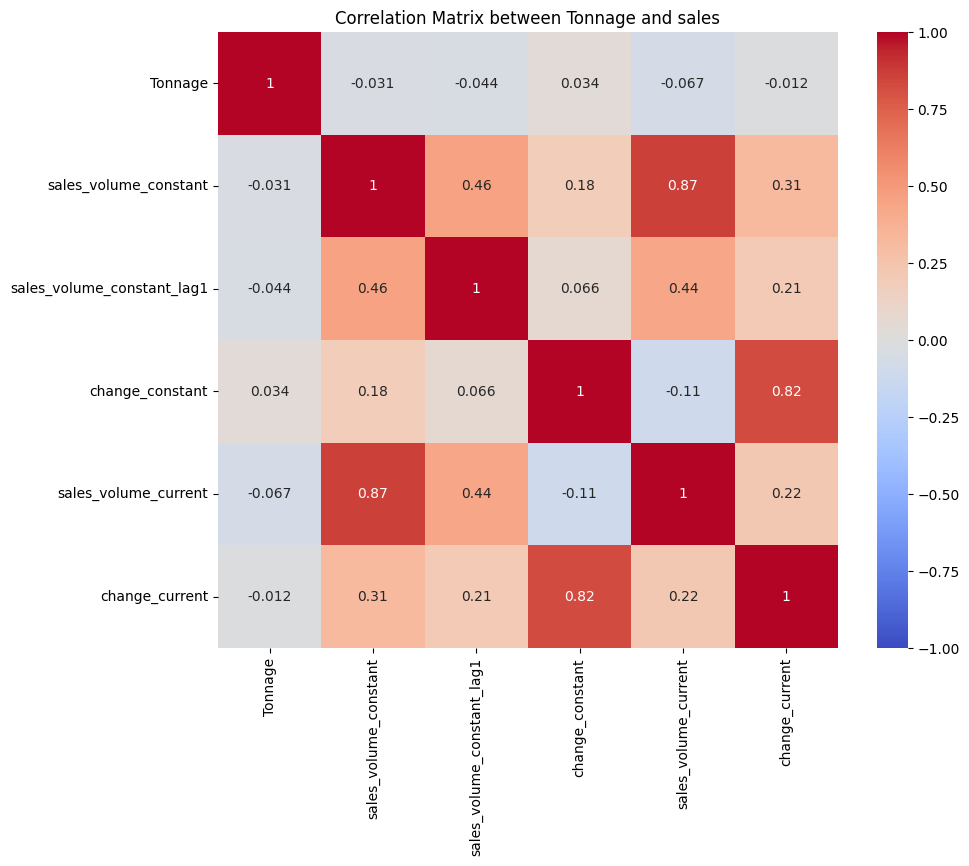

In [ ]:
import seaborn as sns

# Berechne die Korrelationsmatrix
correlation_matrix = df_bsr[['Tonnage', 
                             'sales_volume_constant',
                             'sales_volume_constant_lag1',
                             'sales_volume_constant_lag2',
                             'sales_volume_constant_lag3',
                             'change_constant',
                             'change_constant_lag1',
                             'change_constant_lag2',
                             'change_constant_lag3', 
                             'sales_volume_current',
                             'sales_volume_current_lag1',
                             'sales_volume_current_lag2',
                             'sales_volume_current_lag3', 
                             'change_current',
                             'change_current_lag1',
                             'change_current_lag2',
                             'change_current_lag3'
                             ]].corr()

# Drucke die Korrelationsmatrix
print("correlation matrix:")
print(correlation_matrix)

# plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Tonnage and sales')
plt.show()